# FUGURE 3 - differential analysis

Differential analysis of the (mean) abundances over H and U subsets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

taxonomic_table  = pd.read_parquet("../DATA/datasets/remapped/taxonomic_table.parq")
functional_table = pd.read_parquet("../DATA/datasets/remapped/functional_table.parq")
ishealthy = pd.read_parquet("../DATA/metadata/remapped/sample_health.parq")["ishealthy"]
fg_annot  = pd.read_parquet("../DATA/metadata/remapped/functional_groups_mapping.parq").loc[functional_table.index]

from utils import rolling_average, asymmetric_std, add_binw_patch

## Compute

In [2]:
def compute_differential_abundance_null_hist(dataset,ishealthy,repeats=150,lim=1.5,nbins=7,window=1,resolution=15):
    
    # refine effective nbins and rolling window
    nbins_e  = nbins*resolution
    window_e = window*resolution

    # container for hists of replicas
    hist = np.zeros(shape=(nbins_e,repeats))

    # sample from null model
    with np.errstate(divide='ignore', invalid='ignore'):
        for i in range(repeats):
            # define splitting
            mask = np.random.permutation(ishealthy)

            # log difference of MADs between splitted datasets
            a = np.log10(dataset.loc[:,~mask].mean(axis=1))- np.log10(dataset.loc[:,mask].mean(axis=1))  # U - H

            # compute histogram
            hist[:,i],bins = np.histogram(a,range=(-lim,lim),bins=nbins_e)
        
    # normalize histogram to density
    hist /= (hist.sum(axis=0)[None,:]*(bins[1]-bins[0]))

    null_model = pd.DataFrame(hist, index=pd.Index(data=0.5*(bins[1:]+bins[:-1]),name="bin_center") )
    null_model = rolling_average(null_model,window=window_e)
    
    # compute average and std+-
    null_model["null_hist_mean"] = null_model.mean(axis=1)
    null_model["null_hist_std-"],null_model["null_hist_std+"] = asymmetric_std(null_model)

    return null_model[["null_hist_mean","null_hist_std-","null_hist_std+"]]


def compute_differential_abundance_hist(dataset,ishealthy,null_rep=150,lim=1.5,nbins=10,window=1,resolution=15):

    # refine effective nbins and rolling window
    nbins_e  = nbins*resolution
    window_e = window*resolution

    # compute ranks
    Xmad = dataset.loc[:, ishealthy].mean(axis=1)
    Ymad = dataset.loc[:,~ishealthy].mean(axis=1)
    
    # projection on log-log intercept variable
    with np.errstate(divide='ignore', invalid='ignore'):
        a = np.log10(Ymad)-np.log10(Xmad)

    # compute histrogram
    if lim is None: lim = max(abs(min(a[np.isfinite(a)])),abs(max(a[np.isfinite(a)])))
    hist, bins = np.histogram(a,range=(-lim,lim),bins=nbins_e,density=True)

    dexpr = pd.DataFrame({"hist"       : hist,
                          "bin_center" : 0.5*(bins[1:]+bins[:-1]) }).set_index("bin_center")
    dexpr = rolling_average(dexpr,window=window_e)

    # compute null model and add to dexpr dataframe
    null_model = compute_differential_abundance_null_hist(dataset,ishealthy,repeats=null_rep,lim=lim,nbins=nbins,resolution=resolution,window=window)
    dexpr = pd.concat([dexpr,null_model],axis=1)

    # add binwidth metadata
    dexpr.binw = (bins[1]-bins[0])*resolution*window

    return dexpr


def compute_differential_abundance_hist2(dataset,ishealthy,fg_annot,null_rep=150,lim=1.5,nbins=10,window=1,resolution=15):
# version 2 computes also the division in COG Categories

    # refine effective nbins and rolling window
    nbins_e  = nbins*resolution
    window_e = window*resolution

    # compute ranks
    Xmad = dataset.loc[:, ishealthy].mean(axis=1)
    Ymad = dataset.loc[:,~ishealthy].mean(axis=1)
    
    # projection on log-log intercept variable
    with np.errstate(divide='ignore', invalid='ignore'):
        a = np.log10(Ymad)-np.log10(Xmad)

    # compute histrogram
    if lim is None: lim = max(abs(min(a[np.isfinite(a)])),abs(max(a[np.isfinite(a)])))
    hist, bins = np.histogram(a,range=(-lim,lim),bins=nbins_e,density=True)
    dexpr = pd.DataFrame({"hist"       : hist,
                          "bin_center" : 0.5*(bins[1:]+bins[:-1]) }).set_index("bin_center")
    
    # compute null model and add to dexpr dataframe
    null_model = compute_differential_abundance_null_hist(dataset,ishealthy,repeats=null_rep,lim=lim,nbins=nbins,resolution=resolution,window=window)
    dexpr = pd.concat([dexpr,null_model],axis=1)

    # histogram splitted in cathegories
    for fg in fg_annot:
        dexpr[fg] = np.histogram(a,range=(-lim,lim),bins=nbins_e,weights=fg_annot[fg])[0]
    norm = np.sum(dexpr[fg_annot.columns].sum())*(bins[1]-bins[0])
    dexpr[fg_annot.columns]/=norm

    dexpr = rolling_average(dexpr,window=window_e)

    

    # add binwidth metadata
    dexpr.binw = (bins[1]-bins[0])*resolution*window

    return dexpr


### Compute all

In [3]:
def compute_figure_3(dataset_tax,dataset_fun,ishealthy,fg_annot,nbins=18):
    dexpr_tax  = compute_differential_abundance_hist (dataset_tax,ishealthy         ,null_rep=150,lim=1.5,nbins=nbins,window=1,resolution=20)
    dexpr_fun  = compute_differential_abundance_hist (dataset_fun,ishealthy         ,null_rep=150,lim=1.5,nbins=nbins,window=1,resolution=20)
    dexpr_fun2 = compute_differential_abundance_hist2(dataset_fun,ishealthy,fg_annot,null_rep=150,lim=1.5,nbins=nbins,window=1,resolution=20)
    return dataset_tax, dataset_fun, ishealthy, fg_annot, dexpr_tax, dexpr_fun, dexpr_fun2

DATA = compute_figure_3(taxonomic_table,functional_table,ishealthy,fg_annot)

## Plot

### MAD comparison

In [4]:
def visualize_MAD_comparison(dataset,ishealthy,ax=None,title="MAD comparison",color="royalblue",grid=True,fontsize=13):
    
    # compute MAD
    Hmad = dataset.loc[:, ishealthy].mean(axis=1)
    Umad = dataset.loc[:,~ishealthy].mean(axis=1)

    # initialize figure
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=[7,7])

    # min max vals
    m = min(Hmad)
    M = max(Hmad)

    # scatter plot
    ax.set_title(title)
    ax.scatter(Hmad,Umad,alpha=0.08,color=color)
    ax.plot([m,M],[m,M], color="black", linestyle="--" )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("MA values (H)",fontsize=fontsize)
    ax.set_ylabel("MA values (U)",fontsize=fontsize)
    ax.grid(grid)

### Differential Mean Abundance

In [5]:
# define default value for params
default_params = {}
default_params["H"] = {"linestyle" : "-" , 
                       "alpha"     : 0.9 ,
                       "linewidth" : 0.45,
                       "color"     : "dodgerblue" }
default_params["U"] = {"linestyle" : "--" , 
                       "alpha"     : 0.9 ,
                       "linewidth" : 0.45,
                       "color"     : "darkorange" }


def visualize_differential_abundance(dexpr,ax=None,title="Differential abundance between H and U sets",polish=True,logy=False,grid=True,color="deepskyblue",linestyle="-",fontsize=13):

    # if ax is passed from outside set current axis to it
    show=False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        show=True

    # plot null model
    x  = dexpr.index
    y1 = dexpr["null_hist_mean"]-dexpr["null_hist_std-"]
    y2 = dexpr["null_hist_mean"]+dexpr["null_hist_std+"]
    null_handler1=ax.fill_between(x,y1,y2,alpha=0.2,color="grey",label=f"null model $(\pm1\sigma)$")
    null_handler2,=ax.plot(x,dexpr["null_hist_mean"],color="grey",linestyle="--",linewidth=0.6)

    # plot main hist
    delta = dexpr.index[1]-dexpr.index[0]
    #ax.bar(dexpr.index-delta/2,dexpr["hist"],width=delta,label="log difference")
    if polish: handler,=ax.plot(dexpr.index,dexpr["hist"],label="log difference of MAs",color=color,linewidth=2,linestyle=linestyle)
    else     : handler=ax.step(dexpr.index,dexpr["hist"],label="log difference of MAs",where="mid",color=color,linestyle=linestyle)

    # tune plot
    ax.set_title(title)
    ax.set_xlabel(r"$\log_{10}($MA$_U) - \log_{10}($MA$_H)$",fontsize=fontsize)
    ax.set_ylabel("Density",fontsize=fontsize)
    #ax.legend()
    if grid: ax.grid(True)
    if logy: ax.set_yscale("log")

    # binwidth patch
    add_binw_patch(ax,binw=dexpr.binw)

    # display if ax is not managed from outside
    if show: plt.show()

    return handler,null_handler1,null_handler2


def visualize_differential_abundance2(dexpr,fg_annot,ax=None,title="Differential abundance between H and U sets",polish=True,logy=False,grid=False,color="deepskyblue",fontsize=13):
# with division in functional categories

    #groups_subset = ["G","P","D","J","O"]
    groups_subset = fg_annot.columns

    # if ax is passed from outside set current axis to it
    show=False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        show=True

    # plot null model
    x  = dexpr.index
    y1 = dexpr["null_hist_mean"]-dexpr["null_hist_std-"]
    y2 = dexpr["null_hist_mean"]+dexpr["null_hist_std+"]
    null_handler1  = ax.fill_between(x,y1,y2,alpha=0.4,color="yellow")
    null_handler2, = ax.plot(x,dexpr["null_hist_mean"],color="grey",linestyle="--",linewidth=0.8)

    # plot main hist
    stack_handler = ax.stackplot(dexpr.index,dexpr[groups_subset].T,labels=groups_subset,alpha=0.8)
    #first_legend = ax.legend(loc="upper left",ncols=2,fancybox=True, shadow=False,fontsize=6,) # ,title="COG Categories"

    # overline
    handler, = ax.plot(dexpr.index,dexpr["hist"],label="log difference of MAs",color=color,linewidth=2,linestyle="--")

    # tune plot
    ax.set_title(title)
    ax.set_xlabel(r"$\log_{10}($F-MA$_U) - \log_{10}($F-MA$_H)$",fontsize=fontsize)
    ax.set_ylabel("Density",fontsize=fontsize)
    #ax.legend()
    if grid: ax.grid(True)
    if logy: ax.set_yscale("log")

    # binwidth patch
    _, proxy_artist = add_binw_patch(ax,binw=dexpr.binw)

    # display if ax is not managed from outside
    if show: plt.show()

    return handler, null_handler1, null_handler2, stack_handler

#visualize_differential_abundance2(dexpr_hist_fun,fg_annot)


### Plot all

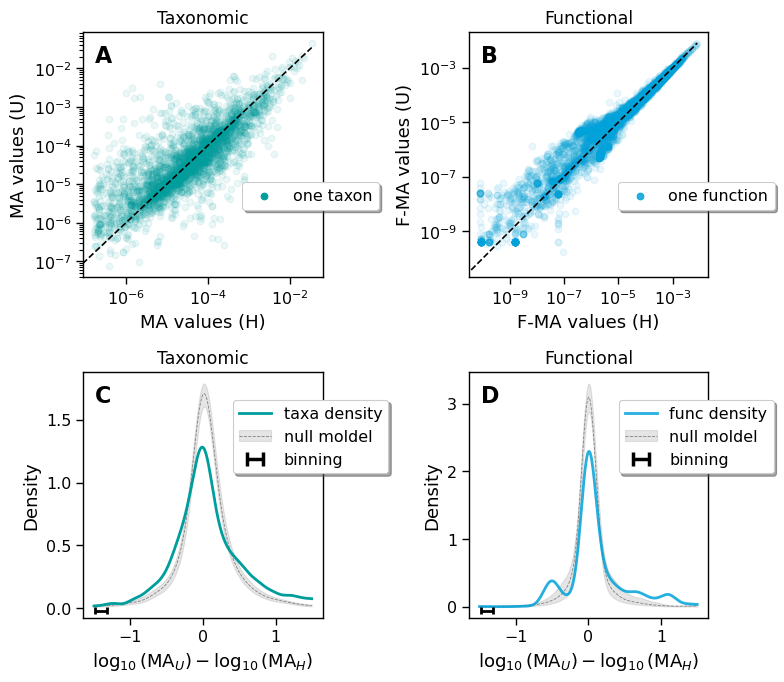

In [6]:
def plot_figure_3(DATA,savepath=None,stackplot=False,show=True,suptitle=None):

    import matplotlib as mpl
    import seaborn as sns
    sns.set_context('paper', font_scale=1.3)

    # unpack
    dataset_tax, dataset_fun, ishealthy, fg_annot, dexpr_tax, dexpr_fun, dexpr_fun2 = DATA

    #groups_subset = ["G","P","D","J","O"]
    groups_subset = fg_annot.columns



    # define parameters
    color_tax = np.minimum(1,np.array(mpl.colors.to_rgba("darkcyan"))*1.13) #"darkcyan" #"mediumseagreen"
    color_fun = np.array(mpl.colors.to_rgba("deepskyblue"))*0.85 #"deepskyblue" #"blueviolet" #"royalblue"
    fontsize = 13

    fig, axs = plt.subplots(2,2, figsize=[8,7])
    if suptitle is not None:
        fig.suptitle(suptitle)
        
    visualize_MAD_comparison(dataset_tax,ishealthy,ax=axs[0,0],color=color_tax,fontsize=fontsize,title="Taxonomic")
    visualize_MAD_comparison(dataset_fun,ishealthy,ax=axs[0,1],color=color_fun,fontsize=fontsize,title="Functional")
    
    tax_handler, tax_null_handler1, tax_null_handler2 = visualize_differential_abundance(dexpr=dexpr_tax,ax=axs[1,0],color=color_tax,fontsize=fontsize,title="Taxonomic" ,linestyle="-")
    if stackplot:
        fun_handler, fun_null_handler1, fun_null_handler2, stack_handler = visualize_differential_abundance2(dexpr=dexpr_fun2,fg_annot=fg_annot,ax=axs[1,1],color=color_fun,fontsize=fontsize,title="Functional")
    else:
        fun_handler, fun_null_handler1, fun_null_handler2 = visualize_differential_abundance(dexpr=dexpr_fun,ax=axs[1,1],color=color_fun,fontsize=fontsize,title="Functional",linestyle="-")

    ## LEGENDS
    # above
    axs[0,0].scatter([None],[None],color=color_tax,label="one taxon")
    axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.95, 0.42),ncol=1, fancybox=True, shadow=True)
    axs[0,1].scatter([None],[None],color=color_fun,label="one function")
    axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.95, 0.42),ncol=1, fancybox=True, shadow=True)
    # below, tax
    import warnings
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        binning_proxy_artist = axs[1,0].errorbar([np.nan],[np.nan],xerr=[1], capsize=5,linewidth=2.5,capthick=2.5,color="black",label="binning",linestyle="")
    axs[1,0].legend([tax_handler,(tax_null_handler1,tax_null_handler2),binning_proxy_artist],
                    ["taxa density","null moldel","binning"],
                    loc='upper center', bbox_to_anchor=(0.95, 0.92),ncol=1, fancybox=True, shadow=True)
    # below, fun
    if stackplot:
        first_legend = axs[1,1].legend(stack_handler,groups_subset,
                                    loc="upper left",bbox_to_anchor=(0.02, 0.86),ncols=2,fancybox=True, shadow=False,fontsize=6) # ,title="COG Categories"
        axs[1,1].add_artist(first_legend)
        axs[1,1].legend([fun_handler,(fun_null_handler1,fun_null_handler2),binning_proxy_artist],
                        ["func density","null moldel","binning"],
                        loc='upper center', bbox_to_anchor=(0.95, 0.92),ncol=1, fancybox=True, shadow=True)
    else: 
        axs[1,1].legend([fun_handler,(fun_null_handler1,fun_null_handler2),binning_proxy_artist],
                    ["func density","null moldel","binning"],
                    loc='upper center', bbox_to_anchor=(0.95, 0.92),ncol=1, fancybox=True, shadow=True)

    # subplot name patches, and global modifications
    for ax,label in zip(axs.ravel(),('A', 'B', 'C', 'D')):
        ax.text(x=0.05, y=0.95, s=label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
        ax.grid(False)
    plt.tight_layout()

    # rewrite functional labels
    tax_xlabel = axs[0,0].get_xlabel()
    tax_ylabel = axs[0,0].get_ylabel()
    axs[0,1].set_xlabel(f"F-{tax_xlabel}")
    axs[0,1].set_ylabel(f"F-{tax_ylabel}")


    # export images/display
    if savepath is not None: plt.savefig(fname=savepath, dpi="figure", format="pdf")
    if show: plt.show()
    else: plt.close()

# plot/save
plot_figure_3(DATA,savepath="../RESULTS/Figure_3_differential_analysis.pdf",stackplot=False)